In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import gaussian_kde
from sklearn.model_selection import cross_val_score, KFold
# load data
D=np.loadtxt('/content/icevelocity.txt')

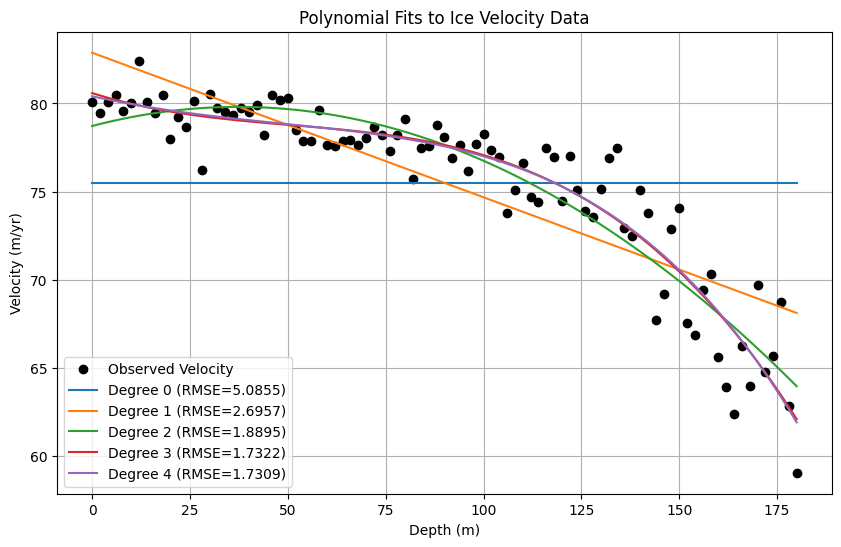

Polynomial degree 0: RMSE = 5.0855
Polynomial degree 1: RMSE = 2.6957
Polynomial degree 2: RMSE = 1.8895
Polynomial degree 3: RMSE = 1.7322
Polynomial degree 4: RMSE = 1.7309


In [11]:
#  Question No 1:
z=D[:, 0]  # Depth
v=D[:, 1]  # Observed velocity

# Define polynomial degrees
degrees = [0, 1, 2, 3, 4]

# Initialize list to store RMSE values
rmse_values = []

# Plot original data
plt.figure(figsize=(10, 6))
plt.plot(z, v, 'ko', label='Observed Velocity')

# Fit and plot polynomial models for each degree
for degree in degrees:
    # Fit polynomial model
    coefficients = np.polyfit(z, v, degree)

    # Evaluate polynomial at given depths
    vm = np.polyval(coefficients, z)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((vm - v) ** 2))
    rmse_values.append(rmse)

    # Plot the polynomial fit
    plt.plot(z, vm, label=f'Degree {degree} (RMSE={rmse:.4f})')

# Add legend and labels
plt.legend()
plt.xlabel('Depth (m)')
plt.ylabel('Velocity (m/yr)')
plt.title('Polynomial Fits to Ice Velocity Data')
plt.grid(True)
plt.show()

# Print RMSE values
for degree, rmse in zip(degrees, rmse_values):
    print(f'Polynomial degree {degree}: RMSE = {rmse:.4f}')

In [12]:
#  Question No 2:
import numpy as np
import random

# By setting the random seed for reproducibility
np.random.seed(42)

# Initializing variables
num_simulations = 1000
degrees = [0, 1, 2, 3, 4]
sampling_percent = 90  # percentage of data to sample

# Sample splitting function
def getTrainTest(D, pTrain):
    """
    Partitions dataset into training and testing subsets.
    :param data: dataset
    :param pTrain: percentage of the dataset used to train the model
    :return: training and testing sets
    """
    pTrain /= 100  # Converting percentage to decimal
    num_samples = len(D)
    num_train_samples = int(round(pTrain * num_samples))

    indices = np.arange(num_samples)
    train_indices = np.random.choice(indices, num_train_samples, replace=False)
    test_indices = np.setdiff1d(indices, train_indices)

    return D[train_indices], D[test_indices]

# Monte Carlo simulation for fitting polynomial models
def monte_carlo_param(D, degree, percent, trials=1000):
    """
    Monte Carlo simulation for fitting models to random data samples.
    :param data: dataset
    :param degree: polynomial degree
    :param percent: percentage of data to sample
    :param trials: number of simulations
    :return: array of coefficients for each simulation
    """
    coef_df = np.zeros((trials, degree + 1))
    for i in range(trials):
        train_data, _ = getTrainTest(D, percent)
        coef_df[i] = np.polyfit(train_data[:, 0], train_data[:, 1], degree)
    return coef_df

# Statistical summary function for the simulation results
def monte_stat_table(coefs, degree):
    """
    Generates summary statistics (mean, std) for the coefficients.
    :param coefs: coefficients from simulations
    :param degree: highest polynomial degree
    :return: summary statistics as a DataFrame
    """
    stats = {"mean": np.mean(coefs, axis=0), "std": np.std(coefs, axis=0)}
    row_names = [f"x^{i}" for i in range(degree, -1, -1)]
    return pd.DataFrame(stats, index=row_names)

# Assuming z and v are columns in a dataset `data` with shape (n_samples, 2)
data = np.column_stack((z, v))

# By runing simulations for each polynomial degree
monte_results = {deg: monte_carlo_param(data, deg, sampling_percent) for deg in degrees}

# Displaying mean and standard deviation of coefficients for each polynomial model
print("Mean coefficient for each polynomial model, standard deviation of each coefficient")
for degree in degrees:
    print(f"Degree {degree} polynomial:")
    print(monte_stat_table(monte_results[degree], degree))
    print()

Mean coefficient for each polynomial model, standard deviation of each coefficient
Degree 0 polynomial:
          mean       std
x^0  75.495159  0.179161

Degree 1 polynomial:
          mean       std
x^1  -0.082130  0.002208
x^0  82.885093  0.162413

Degree 2 polynomial:
          mean       std
x^2  -0.000778  0.000031
x^1   0.058074  0.004938
x^0  78.719920  0.160241

Degree 3 polynomial:
          mean           std
x^3  -0.000007  6.133915e-07
x^2   0.001012  1.486153e-04
x^1  -0.070114  9.464109e-03
x^0  80.593486  1.522628e-01

Degree 4 polynomial:
             mean           std
x^4 -1.373458e-08  1.423186e-08
x^3 -1.731015e-06  4.706304e-06
x^2  4.520595e-04  4.949255e-04
x^1 -4.820020e-02  1.794198e-02
x^0  8.040559e+01  1.640461e-01



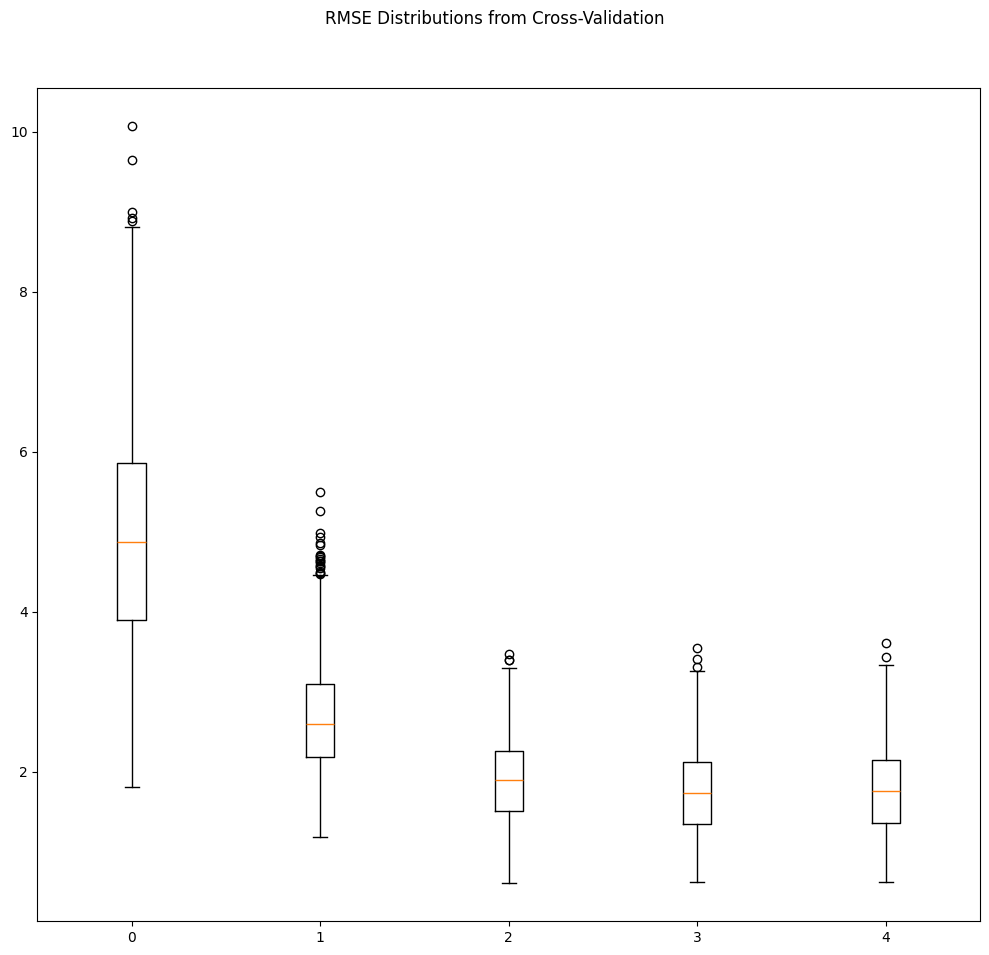

In [13]:
#  Question No 3: Perform a cross-validation, using 90% of the data to fit the 5 polynomial models, and the remaining 10% of
#data to test, repeating 1000 times. Plot the distribution of RMSE values for each degree polynomial.
num_samples_train = 82  #  Training set Number of samples
num_samples_test = 9    # Test set Number of samples
num_simulations = 1000

# Initializing arrays to store data for cross-validation
all_z_train = np.zeros((num_samples_train, num_simulations))
all_v_train = np.zeros((num_samples_train, num_simulations))
all_z_test = np.zeros((num_samples_test, num_simulations))
all_v_test = np.zeros((num_samples_test, num_simulations))

# Generating partitions for cross-validation
for i in range(num_simulations):
    indices = np.random.permutation(len(z))
    train_indices = indices[:num_samples_train]
    test_indices = indices[num_samples_train:num_samples_train + num_samples_test]

    all_z_train[:, i] = z[train_indices]
    all_v_train[:, i] = v[train_indices]
    all_z_test[:, i] = z[test_indices]
    all_v_test[:, i] = v[test_indices]

# By defining cross-validation function
def cross_val(z_train, v_train, z_test, v_test, degree):
    coefficients = np.polyfit(z_train, v_train, degree)
    v_pred = np.polyval(coefficients, z_test)
    return np.sqrt(np.mean((v_pred - v_test) ** 2))

# Initializing dictionary to store RMSE values for each degree
rmse_cross_val = {degree: [] for degree in degrees}

# Run cross-validation for each degree
for degree in degrees:
    for i in range(num_simulations):
        rmse = cross_val(all_z_train[:, i], all_v_train[:, i], all_z_test[:, i], all_v_test[:, i], degree)
        rmse_cross_val[degree].append(rmse)

# Ploting RMSE distributions
plt.figure(figsize=(10, 10))
for i, degree in enumerate(degrees, 1):
    #plt.subplot(len(degrees), 1, i)
    #plt.xlim(0, 10)
    #plt.hist(rmse_cross_val[degree], bins=40, density=True, alpha=0.7, label=f'Degree {degree}')
    plt.boxplot(rmse_cross_val[degree], positions=[degree])
    #plt.xlabel('RMSE')
    #plt.legend()
plt.suptitle('RMSE Distributions from Cross-Validation')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

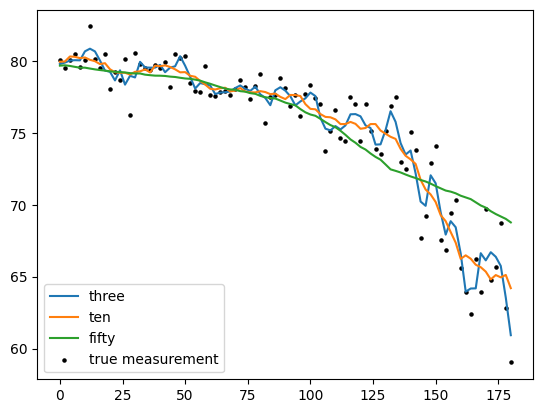

In [ ]:
#  Question No 4:
import numpy as np
import matplotlib.pyplot as plt
# load data
data=np.loadtxt('/content/icevelocity.txt')
depth = data[:, 0]  # Depth
velocity = data[:, 1]  # Observed velocity
window_sizes = [ 3,10,50]
mean_within_window = np.zeros((91,3))
for i in range(len(window_sizes)):
  for j in range(len(depth)):
    points_within_window = np.logical_and(depth > (depth[j] - window_sizes[i]), depth < (depth[j] + window_sizes[i]))
    mean_within_window[j,i] = np.mean(velocity[points_within_window])
#mean_within_window

plt.plot(depth, mean_within_window[:, 0], label="three")
plt.plot(depth, mean_within_window[:, 1], label="ten")
plt.plot(depth, mean_within_window[:, 2], label="fifty")
plt.scatter(depth, velocity, color="k", s=5, label="true measurement")
plt.legend()
plt.show()

In [15]:
#  Question No 5:
def non_parametric(x_values, y_values, idx, win_size):
  res =  np.zeros(len(idx))
  for i in range(len(idx)):
    dist = np.sqrt((x_values - idx[i])**2)
    idx_value = np.where(dist < win_size)

    if idx_value is None:
      res = np.nan
    else:
      weight = 15/16 * (1 - (dist[idx_value]/win_size)**2)**2
      res[i] = np.sum(weight * y_values[idx_value])/np.sum(weight)

  return res

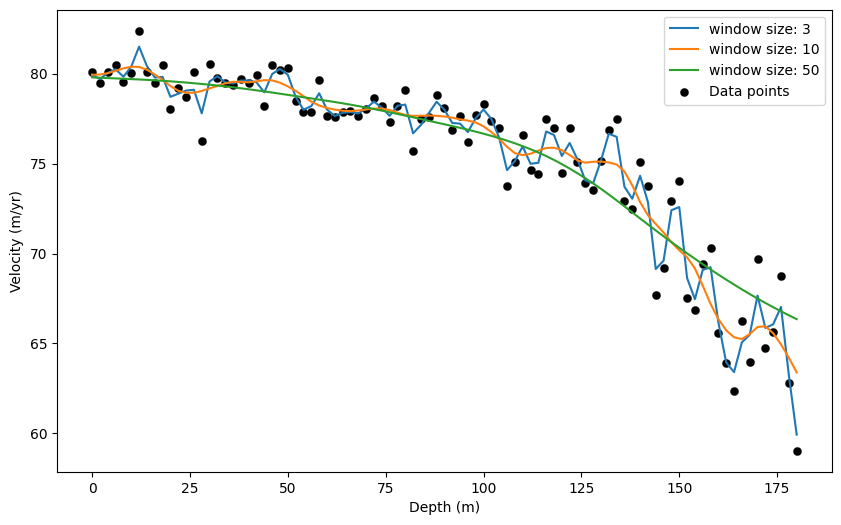

In [17]:
window_sizes  = [3,10,50]
mean_within_window4 = np.zeros((91, 3))
for i in range(len(window_sizes)):
  mean_within_window4[:,i] = non_parametric(x_values=z, y_values=v, idx = z, win_size=window_sizes[i])


plt.figure(figsize=(10, 6))
plt.plot(z, mean_within_window4[:, 0], label="window size: 3")
plt.plot(z, mean_within_window4[:, 1], label="window size: 10")
plt.plot(z, mean_within_window4[:, 2], label="window size: 50")
plt.scatter(z, v, label='Data points', color='black', linewidth=0.15)
plt.legend()
plt.xlabel('Depth (m)')
plt.ylabel('Velocity (m/yr)')
plt.show()

optimal window size: 2 
Optimal rmse: 2.562212898536748e-15 


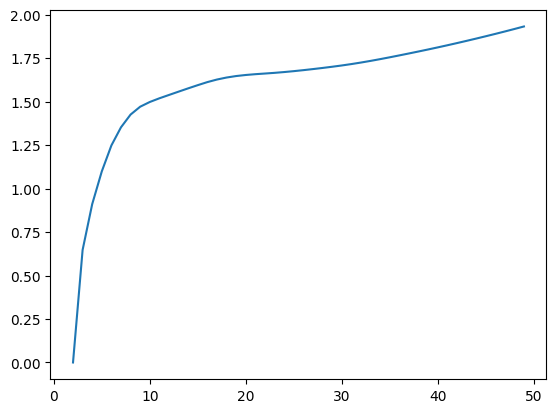

In [18]:
#  Question No 6:
def RMSE(model, actual):
    return np.sqrt(np.nanmean((model - actual) ** 2))

windows = range(2,50)
summary_window_rmse = np.zeros(len(windows))

optimal_window_size = np.inf
optimal_rmse = np.inf

for w in windows:
    window_rmse = np.zeros(1000)
    for ix in range(1000):
        data_z = all_z_train[:, ix]
        data_v = all_v_train[:, ix]
        v_model = non_parametric(all_z_train[:, ix], all_v_train[:, ix], data_z, w)
        window_rmse[ix] = RMSE(v_model, data_v)
    mean_window_rmse =np.nanmean(window_rmse)
    summary_window_rmse[w-2] = mean_window_rmse


    if optimal_rmse >  mean_window_rmse:
        optimal_rmse = mean_window_rmse
        optimal_window_size = w

print(f"optimal window size: {optimal_window_size} \nOptimal rmse: {optimal_rmse} ")
plt.plot(windows, summary_window_rmse)
plt.show()

In [21]:
#  Question No 7: Using the measured velocity at a depth of z = 0 m for the surface velocity, ux,surf , find the optimum values
#for the flow law parameters A and n, using the grid search (brute-force) method.
# Constants that we know
g = 9.81  # gravity (m/s^2)
rho = 917  # ice density (kg/m^3)
theta = np.radians(10)  # slope angle in radians

# Surface velocity (assume observed velocity at depth = 0)
ux_surf = v[0]

# Define a grid of A and n values
A_values = np.arange(1e-18, 6e-18 - 0.1e-18, 0.1e-18)
n_values = np.arange(2.95, 3.4, 0.01)
rmse_grid = np.zeros((len(A_values), len(n_values)))
# Initialize variables to store the optimum A, n, and minimum RMSE
min_rmse = np.inf
optimum_A = None
optimum_n = None

# Grid search
for A in range(len(A_values)):
    for n in range (len(n_values)):
        # Calculate the modeled velocity based on the flow law
        vm = ux_surf - (A_values[A]* (rho * g * np.sin(theta))**n_values[n]) * z**(n_values[n]+1)
        # Calculate RMSE
        rmse = np.sqrt(np.mean((vm - v)**2))
        rmse_grid[A, n] = np.sqrt(np.mean((vm - v)**2))
        # Update optimum values if RMSE is lower
        if rmse < min_rmse:
            min_rmse = rmse
            optimum_A = A_values[A]
            optimum_n = n_values[n]

print(f'Optimum A: {optimum_A}')
print(f'Optimum n: {optimum_n}')
print(f'Minimum RMSE: {min_rmse}')


Optimum A: 5.500000000000002e-18
Optimum n: 2.9899999999999993
Minimum RMSE: 1.9628940934933408


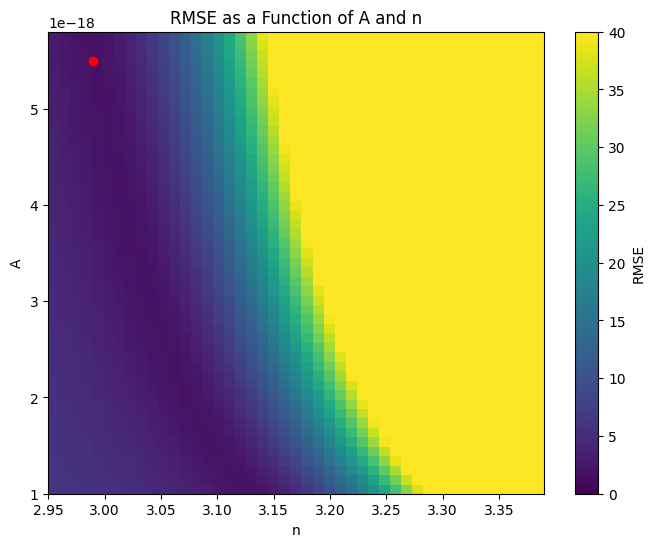

In [22]:
#  Question No 8: Plot the root mean square (RMS) error (mean over all depths) as a function of A and n
import matplotlib.pyplot as plt

# Plot RMSE as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(rmse_grid, extent=[np.min(n_values), np.max(n_values), np.min(A_values), np.max(A_values)], aspect='auto', origin='lower',
           vmin=0, vmax=40)
plt.colorbar(label='RMSE')
plt.plot(optimum_n, optimum_A, 'ro')
plt.xlabel('n')
plt.ylabel('A')
plt.title('RMSE as a Function of A and n')
plt.show()


In [24]:
#  Question No 9: Find optimum values of A and n using the gradient search method with MATLAB’s fminsearch function.
from scipy.optimize import minimize
# gradient_domain = np.linspace(0, 180, 91)

# Initial guess for A
initial_guess = [5e-18]

# Define RMSE function for optimization
def RMSEval(param):
    big_A = param
    vel_model =  ux_surf - (big_A * (rho * g * np.sin(theta))**3) * z**(4)
#     ux_surf - (big_A * (rho * g * np.sin(theta))**3) * z**(4)
    vel_error = np.sqrt(np.mean((vel_model - v) ** 2))
    return vel_error

# Run optimization for this sample
result = minimize(RMSEval, initial_guess)
A_0_min = result.x
print(A_0_min)
print(result)

[5.e-18]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.9790379354038703
        x: [ 5.000e-18]
      nit: 0
      jac: [ 1.360e+18]
 hess_inv: [[1]]
     nfev: 102
     njev: 45


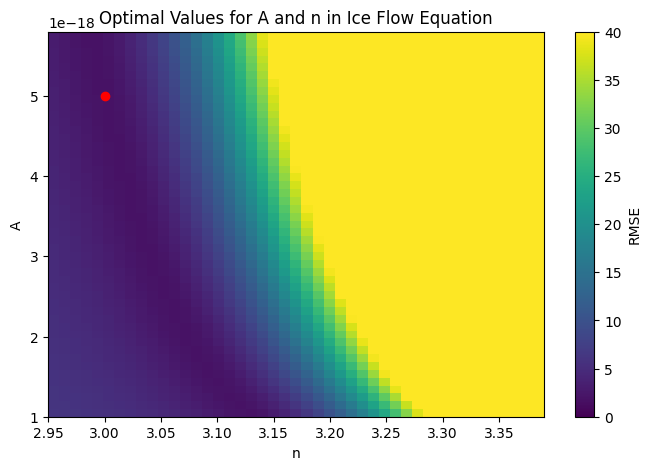

In [25]:
# Plot the heatmap with brute-force, minimize function, and mean A values
plt.figure(figsize=(8,5))

# Heatmap for RMSE values over A and n ranges
plt.imshow(rmse_grid, extent=[np.min(n_values), np.max(n_values), np.min(A_values), np.max(A_values)], aspect='auto',
           origin='lower', cmap='viridis', vmin=0, vmax=40)
plt.plot(3, A_0_min, 'r', marker='o', linewidth=2, label='Brute Force')
plt.xlabel('n')
plt.ylabel('A')
plt.colorbar(label='RMSE')

plt.title('Optimal Values for A and n in Ice Flow Equation')
# plt.legend()
plt.show()

In [27]:
#  Question No 10: Randomly sample 90% of the dataset and find the optimum value of A using the gradient search method,
# and repeat 1000 times. Plot the distribution of A and the RMS error (over all depths) in the model using a
# relative density histogram.
def RMSEval(param):
        big_A = param  # Unpack parameters
        vel_model = ux_surf - big_A * (z_training ** (3 + 1))
        vel_error = np.sqrt(np.mean((vel_model - v_training) ** 2))
        return vel_error


A0_error = np.zeros((1000, 2))
n = optimum_n
for ix in range(1000):
    z_training = all_z_train[:, ix]
    v_training = all_v_train[:, ix]

    this_result = minimize(RMSEval, 2e-8)
    A0_error[ix, 0] = this_result.fun
    A0_error[ix, 1] = this_result.x

print(A0_error)

<ipython-input-27-42177a86b3c9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A0_error[ix, 1] = this_result.x
<ipython-input-27-42177a86b3c9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A0_error[ix, 1] = this_result.x
<ipython-input-27-42177a86b3c9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A0_error[ix, 1] = this_result.x
<ipython-input-27-42177a86b3c9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

[[1.94976230e+00 1.84798166e-08]
 [2.01536277e+00 1.83880609e-08]
 [1.93874421e+00 1.80719164e-08]
 ...
 [2.00678863e+00 1.81269373e-08]
 [2.01651976e+00 1.81946197e-08]
 [1.95620554e+00 1.82256442e-08]]


<ipython-input-27-42177a86b3c9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A0_error[ix, 1] = this_result.x
<ipython-input-27-42177a86b3c9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A0_error[ix, 1] = this_result.x
<ipython-input-27-42177a86b3c9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A0_error[ix, 1] = this_result.x
<ipython-input-27-42177a86b3c9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

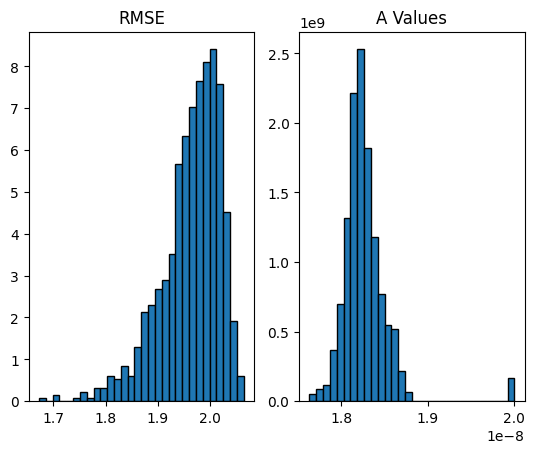

In [28]:
plt.subplot(1,2,1)
plt.hist(A0_error[:, 0], bins=30, density=True, edgecolor='black')
plt.title("RMSE")
plt.subplot(1,2,2)
plt.hist(A0_error[:, 1], bins=30, density=True, edgecolor='black')
plt.title('A Values')
plt.show()

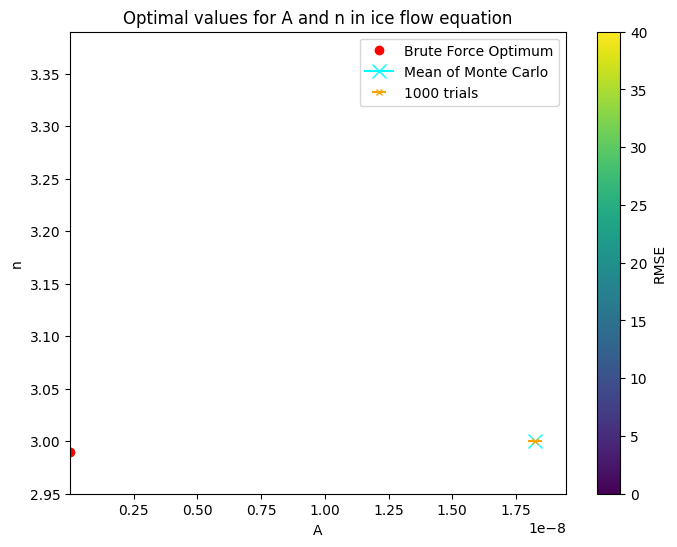

In [29]:
#  Question No 11: Plot the mean optimum values of A and its standard deviation with vertical error bars on your figure from # 7.
plt.figure(figsize=(8, 6))

# Display heatmap
plt.imshow(rmse_grid, extent=[np.min(A_values), np.max(A_values), np.min(n_values), np.max(n_values)],
           aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=40)
plt.colorbar(label='RMSE')
plt.xlabel('A')
plt.ylabel('n')
plt.title('Optimal values for A and n in ice flow equation')

# Brute-force optimum
plt.plot(optimum_A, optimum_n, 'ro', linewidth=2, label='Brute Force Optimum')

# Mean and error from Monte Carlo trials
mean_A = np.mean(A0_error[:, 1])
std_A = np.std(A0_error[:, 1])

# Plot Monte Carlo mean with error bars
plt.plot(mean_A, 3, marker='x', color='cyan', label='Mean of Monte Carlo', markersize=10)
plt.errorbar(mean_A, 3, xerr=std_A, fmt='x', color='orange', label='1000 trials', markersize=5)

plt.legend()
plt.show()

In [30]:
#  Question No 12:
# create a normally distributed dataset of 1000 values by using mean and std. of best values for A_0 and the associated RMSE
mean_A = np.mean(A0_error[:, 1])
std_A = np.std(A0_error[:, 1])
sim_A = np.random.normal(mean_A, std_A, 1000)

mean_RMSE = np.mean(A0_error[:, 0])
std_RMSE = np.std(A0_error[:, 0])
sim_RMSE = np.random.normal(mean_RMSE, std_RMSE, 1000)

In [31]:
#  Question No 13:
from scipy.stats import ks_2samp
# calculate p-value comparing normally distributed A_0 and RMSE (from above) and
#   1000 values of A_0 and RMSE found from monte-carlo simulations
A_stat, A_p = ks_2samp(sim_A, A0_error[:, 1])

print(f'KS-stat for A: {A_stat}\n'
      f'p-value for A: {A_p}')

RMSE_stat, RMSE_p = ks_2samp(sim_RMSE, A0_error[:, 0])
print(f'KS-stat for RMSE: {RMSE_stat}\n'
      f'p-value for RMSE: {RMSE_p}')

KS-stat for A: 0.132
p-value for A: 5.194801845515002e-08
KS-stat for RMSE: 0.086
p-value for RMSE: 0.0012207544622917959
